# Digit Recognition using CNN - Sagnik Ghosh

## Importing the Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

sns.set(style="dark",context="notebook",palette="muted")

print("TensorFlow Version:   "+tf.version.VERSION)
print("Keras Version:   "+tf.keras.__version__)

C:\Users\KIIT\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\KIIT\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\KIIT\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\KIIT\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

TensorFlow Version:   1.14.0
Keras Version:   2.2.4-tf


## Preparing the Dataset

In [2]:
train = pd.read_csv("Dataset/train.csv")
test = pd.read_csv("Dataset/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

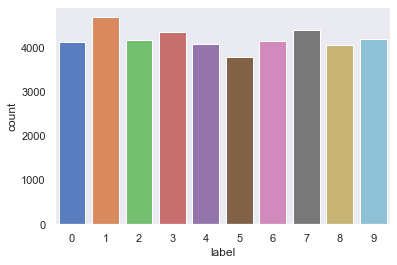

In [3]:
Y_train = train['label']

#Dropping Label Column
X_train = train.drop(labels=['label'],axis=1)

#free up some space
del train

graph = sns.countplot(Y_train)
 
Y_train.value_counts()

In [4]:
#Checking for any null or missing values
X_train.isnull().any().describe()

test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

Normalisation

In [5]:
X_train = X_train/255
test = test/255

Reshape

In [6]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Label Encoding

In [7]:
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=10)
#To enable label into hot vector. For Eg.7 -> [0,0,0,0,0,0,0,1,0,0]

Train and Validation Data Split

In [8]:
#Spliting Train and test set
random_seed =2

X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=0.1, random_state = random_seed)

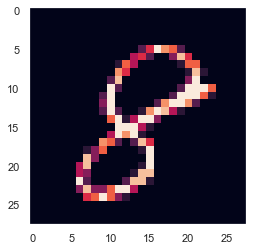

In [9]:
#Show some example 
g = plt.imshow(X_train[0][:,:,0])

## Model Building

In [10]:
#CNN Architecture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
model = tf.keras.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='Same', 
                       activation=tf.nn.relu, input_shape = (28,28,1)))
model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='Same', 
                       activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))


model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='Same', 
                       activation=tf.nn.relu, input_shape = (28,28,1)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='Same', 
                       activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation=tf.nn.relu))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10,activation=tf.nn.softmax))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Optimizers and Annealers

In [11]:
#Defining Optimizer
optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [12]:
#Compiling Model

model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

In [13]:
#Setting Learning rate annealer

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc',
                                                               patience=3,
                                                               verbose=1,
                                                               factor=0.5,
                                                               min_lr=0.00001)

In [14]:
epochs=30
batch_size = 112

Data Augmentation

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

## Model Fitting

In [16]:
if(tf.test.is_built_with_cuda() == True):
    print("CUDA Available.. Just wait a few moments...")
else: 
    print("CUDA not Available.. May the force be with you.")

CUDA not Available.. May the force be with you.


In [17]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
337/337 - 160s - loss: 0.4169 - acc: 0.8647 - val_loss: 0.0645 - val_acc: 0.9788
Epoch 2/30
337/337 - 155s - loss: 0.1159 - acc: 0.9648 - val_loss: 0.0637 - val_acc: 0.9819
Epoch 3/30
337/337 - 166s - loss: 0.0827 - acc: 0.9755 - val_loss: 0.0340 - val_acc: 0.9890
Epoch 4/30
337/337 - 168s - loss: 0.0665 - acc: 0.9797 - val_loss: 0.0316 - val_acc: 0.9881
Epoch 5/30
337/337 - 161s - loss: 0.0607 - acc: 0.9814 - val_loss: 0.0267 - val_acc: 0.9931
Epoch 6/30
337/337 - 179s - loss: 0.0535 - acc: 0.9837 - val_loss: 0.0267 - val_acc: 0.9921
Epoch 7/30
337/337 - 159s - loss: 0.0508 - acc: 0.9847 - val_loss: 0.0316 - val_acc: 0.9900
Epoch 8/30

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
337/337 - 141s - loss: 0.0466 - acc: 0.9859 - val_loss: 0.0226 - val_acc: 0.9926
Epoch 9/30
337/337 - 159s - loss: 0.0359 - acc: 0.9888 - val_loss: 0.0226 - val_acc: 0.9940
Epoch 10/30
337/337 - 160s - loss: 0.0321 - acc: 0.9902 - val_loss: 0.0180 - val_acc: 0.994

## Analyzing the model

KeyError: 'accuracy'

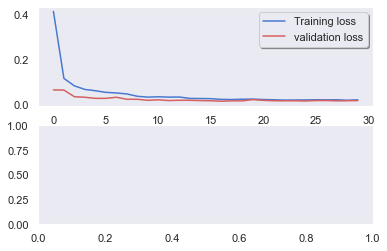

In [19]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Confusion Matrix Plotting

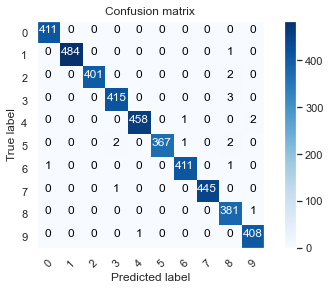

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

Important Error

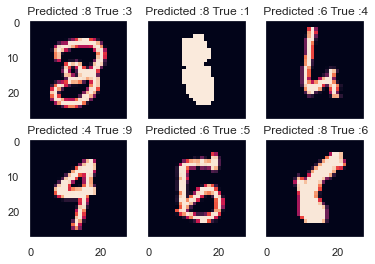

In [21]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title(" Predicted :{} True :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## Predicting the test data

In [22]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [23]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)